## Get Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train_set.csv')
val_df = pd.read_csv ('../input/val_set.csv')
test_df = pd.read_csv('../input/test_set.csv')

In [3]:
print(f'Train Set Shape: {train_df.shape}')
print(f'Validation Set Shape: {val_df.shape}')
print(f'Test Set Shape: {test_df.shape}')

Train Set Shape: (6000, 7)
Validation Set Shape: (1000, 7)
Test Set Shape: (1000, 7)


## Prepare Data

### Train a FastText Model on Data

In [4]:
from gensim.models import FastText

In [5]:
# Size of pretrained embedding
embedding_size = 100

# Word Limit for each input document
max_words = 100

In [6]:
train_sentences = train_df['News Text'].apply(lambda x: x.split()).to_list()

In [7]:
fasttext_model = FastText(sentences=train_sentences, vector_size=embedding_size, window=5, min_count=1, workers=4)

### Representing Each Article as a Vector

In [8]:
import numpy as np

In [9]:
def get_embedding(word):
    try:
        return fasttext_model.wv[word]
    except KeyError:  
        return np.zeros(embedding_size)

def get_article_tensor(article):
    words = article.split()
    word_embeddings = [get_embedding(word) for word in words[:max_words]] 
    
    if len(word_embeddings) < max_words:  # Pad if needed
        word_embeddings += [np.zeros(embedding_size)] * (max_words - len(word_embeddings))
    return np.array(word_embeddings)

In [10]:
# Get Feature Matrix
train_x = np.array([get_article_tensor(article) for article in train_df['News Text']])

val_x = np.array([get_article_tensor(article) for article in val_df['News Text']])

test_x = np.array([get_article_tensor(article) for article in test_df['News Text']])

In [11]:
print(f'Train Features: {train_x.shape}')
print(f'Validation Features Shape: {val_x.shape}')
print(f'Test Features Shape: {test_x.shape}')

Train Features: (6000, 100, 100)
Validation Features Shape: (1000, 100, 100)
Test Features Shape: (1000, 100, 100)


### Get Label Data

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["Category"])
val_y = encoder.transform (val_df["Category"])
test_y = encoder.transform (test_df["Category"])

In [14]:
print(f'train_y shape: {train_y.shape}')
print(f'test_y shape: {val_y.shape}')
print(f'test_y shape: {test_y.shape}')

train_y shape: (6000,)
test_y shape: (1000,)
test_y shape: (1000,)


# Model Training

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D

### Function to Plot Losses

In [18]:
import matplotlib.pyplot as plt

def plot_losses(history):
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(train_loss))
    
    # Plot
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")

    # Labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

### Early Stopping Callback

In [19]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

## Model 1

In [25]:
# create model
model_1 = Sequential()
model_1.add(Input(shape=(max_words, embedding_size)))

model_1.add(Conv1D(32, 3, activation='relu'))
model_1.add(MaxPooling1D(2))

model_1.add(LSTM(4))
model_1.add(Dense(4, activation='sigmoid'))
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [26]:
history_1 = model_1.fit(train_x, train_y, epochs=30, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.6672 - loss: 0.9799 - val_acc: 0.8960 - val_loss: 0.4307
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9078 - loss: 0.3724 - val_acc: 0.9050 - val_loss: 0.3398
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9142 - loss: 0.3112 - val_acc: 0.8860 - val_loss: 0.3391
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9192 - loss: 0.2871 - val_acc: 0.8990 - val_loss: 0.3230
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9208 - loss: 0.2665 - val_acc: 0.9170 - val_loss: 0.3036
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9302 - loss: 0.2558 - val_acc: 0.9190 - val_loss: 0.2857
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9350 - loss: 0.2287 - val_acc: 0.9130 - val_loss: 0.3130
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9370 - loss: 0.2248 - val_acc: 0.9200 - val_loss: 0.3031
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - ac

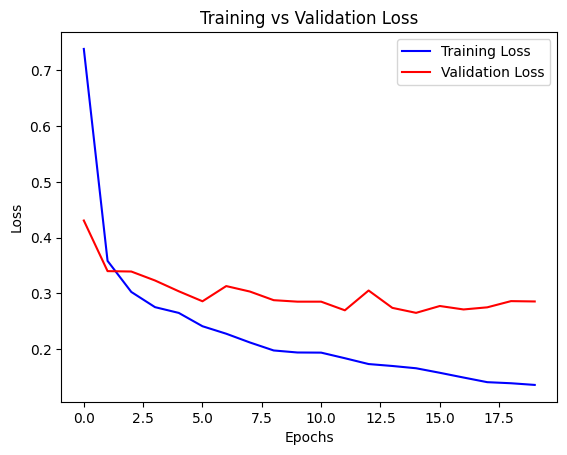

In [27]:
plot_losses(history_1)

### Conclusion: Model reaches overfitting around the 15th epoch

## Model 2

### Increase filters of convolutional layer

In [28]:
# create model
model_2 = Sequential()
model_2.add(Input(shape=(max_words, embedding_size)))

model_2.add(Conv1D(64, 3, activation='relu'))
model_2.add(MaxPooling1D(2))

model_2.add(LSTM(4))
model_2.add(Dense(4, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [29]:
history_2 = model_2.fit(train_x, train_y, epochs=30, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.7157 - loss: 0.8542 - val_acc: 0.8360 - val_loss: 0.4932
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.8885 - loss: 0.3892 - val_acc: 0.9070 - val_loss: 0.3333
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9078 - loss: 0.3152 - val_acc: 0.9100 - val_loss: 0.3198
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9153 - loss: 0.2780 - val_acc: 0.9090 - val_loss: 0.3034
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9200 - loss: 0.2818 - val_acc: 0.9140 - val_loss: 0.3055
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9275 - loss: 0.2442 - val_acc: 0.9250 - val_loss: 0.2819
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9355 - loss: 0.2242 - val_acc: 0.9110 - val_loss: 0.2874
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9380 - loss: 0.2176 - val_acc: 0.9220 - val_loss: 0.3057
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - ac

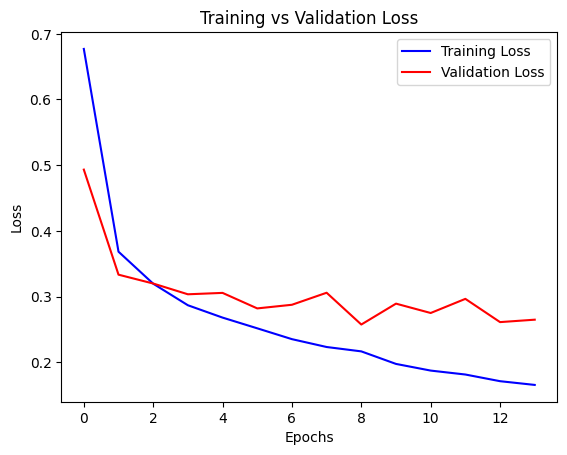

In [30]:
plot_losses(history_2)

### Conclusion: Increasing filter size brings a slight improvement in both loss and accuracy

## Model 3

### Increase Kernel Size

In [33]:
# create model
model_3 = Sequential()
model_3.add(Input(shape=(max_words, embedding_size)))

model_3.add(Conv1D(64, 5, activation='relu'))
model_3.add(MaxPooling1D(2))

model_3.add(LSTM(4))
model_3.add(Dense(4, activation='sigmoid'))
model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [34]:
history_3 = model_3.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.7540 - loss: 0.7843 - val_acc: 0.9010 - val_loss: 0.3855
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9090 - loss: 0.3438 - val_acc: 0.9100 - val_loss: 0.3091
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9124 - loss: 0.3082 - val_acc: 0.9110 - val_loss: 0.3181
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9132 - loss: 0.2937 - val_acc: 0.8900 - val_loss: 0.3447
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9252 - loss: 0.2587 - val_acc: 0.9050 - val_loss: 0.3052
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9328 - loss: 0.2437 - val_acc: 0.9060 - val_loss: 0.3226
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9361 - loss: 0.2256 - val_acc: 0.9190 - val_loss: 0.3025
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.9308 - loss: 0.2307 - val_acc: 0.9250 - val_loss: 0.2821
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - ac

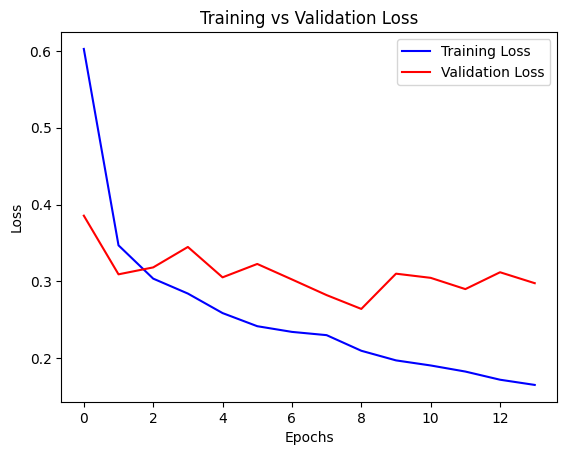

In [35]:
plot_losses(history_3)

### Conclusion: Increasing Kernel Size slightly impairs performance

## Model 4

### Add  Convolutional layer

In [40]:
# create model
model_4 = Sequential()
model_4.add(Input(shape=(max_words, embedding_size)))

model_4.add(Conv1D(64, 3, activation='relu'))
model_4.add(MaxPooling1D(2))

model_4.add(Conv1D(128, 3, activation='relu'))
model_4.add(MaxPooling1D(2))


model_4.add(LSTM(4))
model_4.add(Dense(4, activation='sigmoid'))
model_4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [41]:
history_4 = model_4.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.7841 - loss: 0.7055 - val_acc: 0.8970 - val_loss: 0.3774
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9148 - loss: 0.3131 - val_acc: 0.9050 - val_loss: 0.3509
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9185 - loss: 0.2904 - val_acc: 0.9150 - val_loss: 0.3024
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9313 - loss: 0.2519 - val_acc: 0.9190 - val_loss: 0.2980
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9292 - loss: 0.2456 - val_acc: 0.9200 - val_loss: 0.3104
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9287 - loss: 0.2476 - val_acc: 0.9140 - val_loss: 0.2653
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9329 - loss: 0.2272 - val_acc: 0.9240 - val_loss: 0.2756
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9453 - loss: 0.1957 - val_acc: 0.9270 - val_loss: 0.2711
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - ac

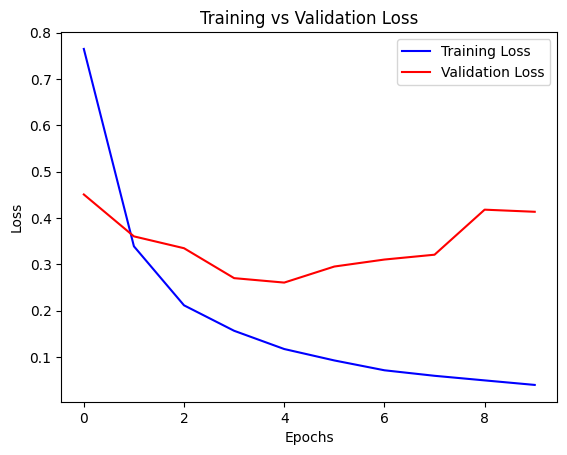

In [51]:
plot_losses(history_4)

### Conclusion: Adding another Convolutional layer improves validation loss but brings about a slight decrease in the validation accuracy

## Model 5

### Add LSTM nodes

In [46]:
# create model
model_5 = Sequential()
model_5.add(Input(shape=(max_words, embedding_size)))

model_5.add(Conv1D(64, 3, activation='relu'))
model_5.add(MaxPooling1D(2))

model_5.add(Conv1D(128, 3, activation='relu'))
model_5.add(MaxPooling1D(2))


model_5.add(LSTM(8))
model_5.add(Dense(4, activation='sigmoid'))
model_5.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [47]:
history_5 = model_5.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.7818 - loss: 0.6527 - val_acc: 0.9130 - val_loss: 0.3113
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9203 - loss: 0.2813 - val_acc: 0.9240 - val_loss: 0.2841
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9249 - loss: 0.2366 - val_acc: 0.9200 - val_loss: 0.2774
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9335 - loss: 0.2291 - val_acc: 0.9150 - val_loss: 0.2877
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9378 - loss: 0.2043 - val_acc: 0.9080 - val_loss: 0.3415
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9386 - loss: 0.2025 - val_acc: 0.9300 - val_loss: 0.2624
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9466 - loss: 0.1813 - val_acc: 0.9310 - val_loss: 0.2554
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9480 - loss: 0.1756 - val_acc: 0.9380 - val_loss: 0.2397
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - ac

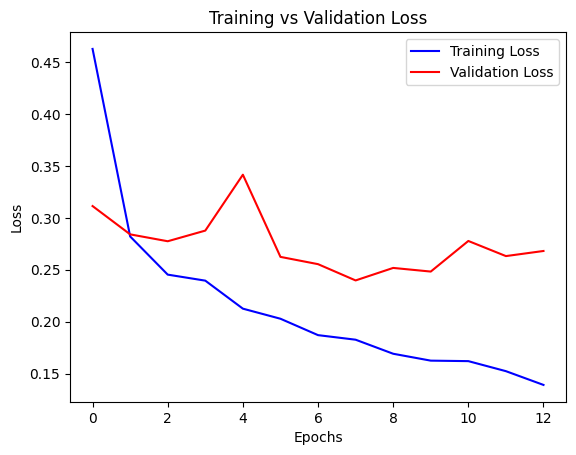

In [48]:
plot_losses(history_5)

### Conclusion: Increasing LSTM nodes to 8 brings a slight improvement in validation loss (0.2397)

## Model 6

### Add LSTM nodes

In [49]:
# create model
model_6 = Sequential()
model_6.add(Input(shape=(max_words, embedding_size)))

model_6.add(Conv1D(64, 3, activation='relu'))
model_6.add(MaxPooling1D(2))

model_6.add(Conv1D(128, 3, activation='relu'))
model_6.add(MaxPooling1D(2))


model_6.add(LSTM(12))
model_6.add(Dense(4, activation='sigmoid'))
model_6.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [50]:
history_6 = model_6.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.8144 - loss: 0.5798 - val_acc: 0.9110 - val_loss: 0.3057
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9175 - loss: 0.2737 - val_acc: 0.9250 - val_loss: 0.2919
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9245 - loss: 0.2493 - val_acc: 0.9250 - val_loss: 0.2867
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9278 - loss: 0.2417 - val_acc: 0.9210 - val_loss: 0.2698
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9355 - loss: 0.2213 - val_acc: 0.9220 - val_loss: 0.2687
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9361 - loss: 0.2206 - val_acc: 0.9300 - val_loss: 0.2578
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9425 - loss: 0.1976 - val_acc: 0.9240 - val_loss: 0.2626
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9460 - loss: 0.1906 - val_acc: 0.9250 - val_loss: 0.2895
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - ac

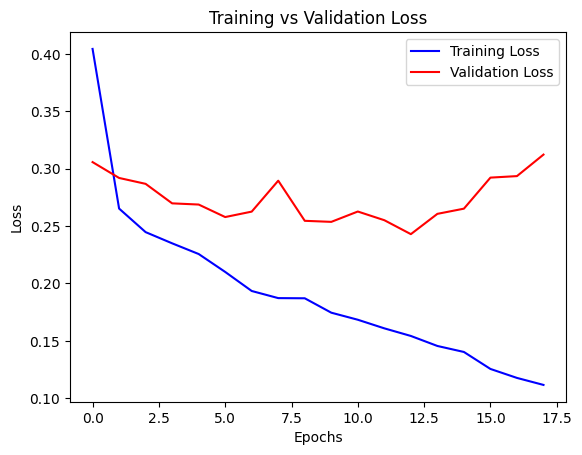

In [51]:
plot_losses(history_6)

### Conclusion: Increasing LSTM nodes to 12 slightly impairs performance

## Model 7

### Add Recurrent Dropout

In [24]:
# create model
model_7 = Sequential()
model_7.add(Input(shape=(max_words, embedding_size)))

model_7.add(Conv1D(64, 3, activation='relu'))
model_7.add(MaxPooling1D(2))

model_7.add(Conv1D(128, 3, activation='relu'))
model_7.add(MaxPooling1D(2))


model_7.add(LSTM(8, recurrent_dropout=0.1))
model_7.add(Dense(4, activation='sigmoid'))
model_7.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [25]:
history_7 = model_7.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - acc: 0.7917 - loss: 0.6499 - val_acc: 0.8950 - val_loss: 0.3400
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9122 - loss: 0.2978 - val_acc: 0.9140 - val_loss: 0.3065
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9219 - loss: 0.2515 - val_acc: 0.9220 - val_loss: 0.2729
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9290 - loss: 0.2554 - val_acc: 0.9220 - val_loss: 0.2804
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.9344 - loss: 0.2302 - val_acc: 0.9170 - val_loss: 0.3014
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.9346 - loss: 0.2309 - val_acc: 0.9200 - val_loss: 0.2855
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.9318 - loss: 0.2401 - val_acc: 0.9100 - val_loss: 0.2851
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.9325 - loss: 0.2287 - val_acc: 0.9300 - val_loss: 0.2629
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - ac

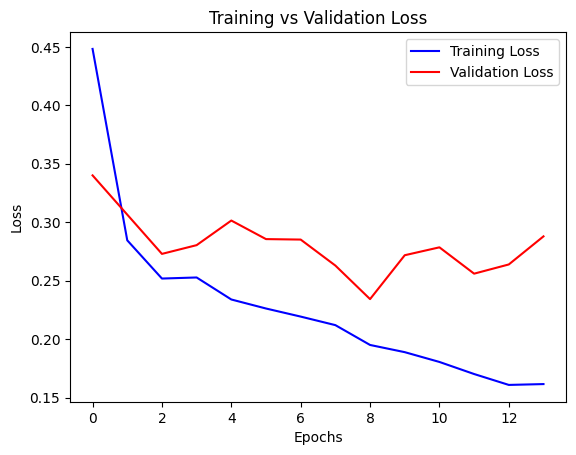

In [26]:
plot_losses(history_7)

### Conclusion: Recurrent dropout slightly improves performance

## Model 8

### Add Regularisation

In [27]:
from keras.regularizers import l2

In [36]:
# create model
model_8 = Sequential()
model_8.add(Input(shape=(max_words, embedding_size)))

model_8.add(Conv1D(64, 3, activation='relu'))
model_8.add(MaxPooling1D(2))

model_8.add(Conv1D(128, 3, activation='relu'))
model_8.add(MaxPooling1D(2))


model_8.add(LSTM(8, recurrent_dropout=0.1, kernel_regularizer=l2(0.001)))
model_8.add(Dense(4, activation='sigmoid'))
model_8.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [37]:
history_8 = model_8.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - acc: 0.8205 - loss: 0.6420 - val_acc: 0.9170 - val_loss: 0.3379
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9124 - loss: 0.3222 - val_acc: 0.9200 - val_loss: 0.2935
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9237 - loss: 0.2673 - val_acc: 0.9250 - val_loss: 0.2823
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9279 - loss: 0.2578 - val_acc: 0.9270 - val_loss: 0.2807
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9363 - loss: 0.2385 - val_acc: 0.9270 - val_loss: 0.2703
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9413 - loss: 0.2156 - val_acc: 0.9110 - val_loss: 0.3100
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9483 - loss: 0.1920 - val_acc: 0.9240 - val_loss: 0.2791
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9465 - loss: 0.1997 - val_acc: 0.9290 - val_loss: 0.2704
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - ac

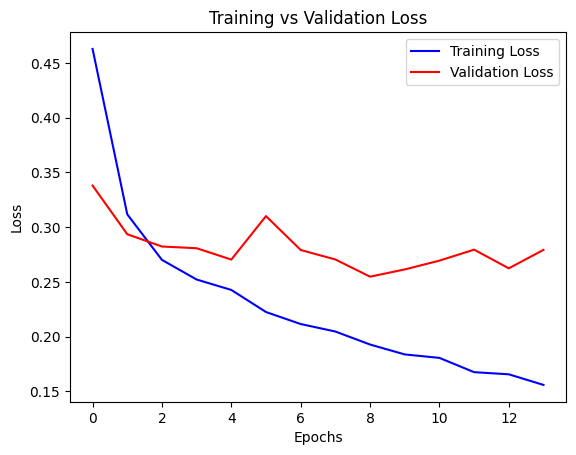

In [38]:
plot_losses(history_8)

### Conclusion: Regularization reduces validation loss

## Model 9

### Add Regularisation without Recurrent Dropout

In [43]:
# create model
model_9 = Sequential()
model_9.add(Input(shape=(max_words, embedding_size)))

model_9.add(Conv1D(64, 3, activation='relu'))
model_9.add(MaxPooling1D(2))

model_9.add(Conv1D(128, 3, activation='relu'))
model_9.add(MaxPooling1D(2))


model_9.add(LSTM(8, kernel_regularizer=l2(0.001)))
model_9.add(Dense(4, activation='sigmoid'))
model_9.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [44]:
history_9 = model_9.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.8107 - loss: 0.6511 - val_acc: 0.9140 - val_loss: 0.3448
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9159 - loss: 0.3002 - val_acc: 0.9230 - val_loss: 0.2852
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9221 - loss: 0.2735 - val_acc: 0.9260 - val_loss: 0.2776
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9273 - loss: 0.2472 - val_acc: 0.9100 - val_loss: 0.3021
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9307 - loss: 0.2405 - val_acc: 0.9270 - val_loss: 0.2944
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9329 - loss: 0.2372 - val_acc: 0.9140 - val_loss: 0.2908
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9391 - loss: 0.2202 - val_acc: 0.9250 - val_loss: 0.2683
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9377 - loss: 0.2177 - val_acc: 0.9380 - val_loss: 0.2504
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - ac

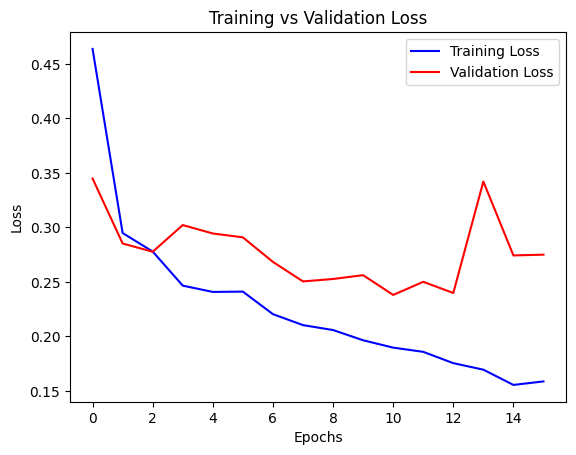

In [46]:
plot_losses(history_9)

### Conclusion: Regularization reduces validation loss

# Get Metrics on Test Set

In [33]:
from sklearn.metrics import classification_report, accuracy_score

In [39]:
y_pred = model_8.predict(test_x)

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0     0.9693    0.8840    0.9247       250
           1     0.9532    0.8960    0.9237       250
           2     0.8688    0.9800    0.9211       250
           3     0.9451    0.9640    0.9545       250

    accuracy                         0.9310      1000
   macro avg     0.9341    0.9310    0.9310      1000
weighted avg     0.9341    0.9310    0.9310      1000

Accuracy: 0.9310


In [45]:
y_pred = model_9.predict(test_x)

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0     0.9498    0.9080    0.9284       250
           1     0.9130    0.9240    0.9185       250
           2     0.9119    0.9520    0.9315       250
           3     0.9676    0.9560    0.9618       250

    accuracy                         0.9350      1000
   macro avg     0.9356    0.9350    0.9350      1000
weighted avg     0.9356    0.9350    0.9350      1000

Accuracy: 0.9350
